# QAOA (Qiskit) — Ising 3x3 (Local AerSimulator)

This notebook implements a QAOA circuit for a 3×3 Ising problem (same as the Cirq example) and runs entirely **locally** using `qiskit` + `qiskit_aer` (no IBM account required).

In [24]:
%pip install qiskit qiskit-aer matplotlib numpy

In [25]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector


In [26]:
# Problem: 3x3 Ising with local field h=0.5
n_rows, n_cols = 3, 3
h = 0.5 * np.ones((n_rows, n_cols))

num_qubits = n_rows * n_cols

# Map 2D grid coordinates to qubit index (row-major)
def idx(i, j):
    return i * n_cols + j

# List of edges (nearest neighbors)
edges = []
for i in range(n_rows):
    for j in range(n_cols):
        if i < n_rows - 1:
            edges.append((idx(i, j), idx(i+1, j)))
        if j < n_cols - 1:
            edges.append((idx(i, j), idx(i, j+1)))

print(f"Number of qubits: {num_qubits}")
print(f"Edges (count={len(edges)}): {edges}")

Number of qubits: 9
Edges (count=12): [(0, 3), (0, 1), (1, 4), (1, 2), (2, 5), (3, 6), (3, 4), (4, 7), (4, 5), (5, 8), (6, 7), (7, 8)]


In [27]:
def cost_layer(gamma: Parameter):
    qc = QuantumCircuit(num_qubits)
    for (a, b) in edges:
        qc.cx(a, b)
        qc.rz(2 * gamma, b)
        qc.cx(a, b)
    for i in range(n_rows):
        for j in range(n_cols):
            q = idx(i, j)
            qc.rz(2 * gamma * h[i, j], q)
    return qc


def mixer_layer(beta: Parameter):
    qc = QuantumCircuit(num_qubits)
    for q in range(num_qubits):
        qc.rx(2 * beta, q)
    return qc


In [28]:
def build_qaoa_circuit(p=1):
    gammas = [Parameter(f'gamma_{i}') for i in range(p)]
    betas = [Parameter(f'beta_{i}') for i in range(p)]

    qc = QuantumCircuit(num_qubits)
    qc.h(range(num_qubits))

    for layer in range(p):
        qc.append(cost_layer(gammas[layer]).to_instruction(), range(num_qubits))
        qc.append(mixer_layer(betas[layer]).to_instruction(), range(num_qubits))

    return qc, gammas, betas

qaoa_circ, gammas, betas = build_qaoa_circuit(p=1)
qaoa_circ.draw('text')

┌───┐┌──────────────────────┐┌─────────────────────┐
q_0: ┤ H ├┤0                     ├┤0                    ├
     ├───┤│                      ││                     │
q_1: ┤ H ├┤1                     ├┤1                    ├
     ├───┤│                      ││                     │
q_2: ┤ H ├┤2                     ├┤2                    ├
     ├───┤│                      ││                     │
q_3: ┤ H ├┤3                     ├┤3                    ├
     ├───┤│                      ││                     │
q_4: ┤ H ├┤4 circuit-79(gamma_0) ├┤4 circuit-82(beta_0) ├
     ├───┤│                      ││                     │
q_5: ┤ H ├┤5                     ├┤5                    ├
     ├───┤│                      ││                     │
q_6: ┤ H ├┤6                     ├┤6                    ├
     ├───┤│                      ││                     │
q_7: ┤ H ├┤7                     ├┤7                    ├
     ├───┤│                      ││                     │
q_8: ┤ H ├┤8                     ├┤8                    ├
     └───┘└──────────────────────┘└─────────────────────┘

In [29]:
def energy_from_statevector(statevec):
    probs = np.abs(statevec.data) ** 2
    n = num_qubits
    energy = 0.0
    for idx_basis, p in enumerate(probs):
        bits = np.array(list(np.binary_repr(idx_basis, width=n)), dtype=int)
        spins = 1 - 2 * bits
        spins = spins.reshape((n_rows, n_cols))
        e = 0.0
        for i in range(n_rows):
            for j in range(n_cols):
                if i < n_rows - 1:
                    e += spins[i, j] * spins[i+1, j]
                if j < n_cols - 1:
                    e += spins[i, j] * spins[i, j+1]
                e += h[i, j] * spins[i, j]
        energy += e * p
    return energy

# Quick test
sv = Statevector.from_instruction(qaoa_circ.assign_parameters([0.5, 0.3]))
print('Statevector length:', len(sv.data))
print('Energy (test):', energy_from_statevector(sv))

Statevector length: 512
Energy (test): 5.224432917996928


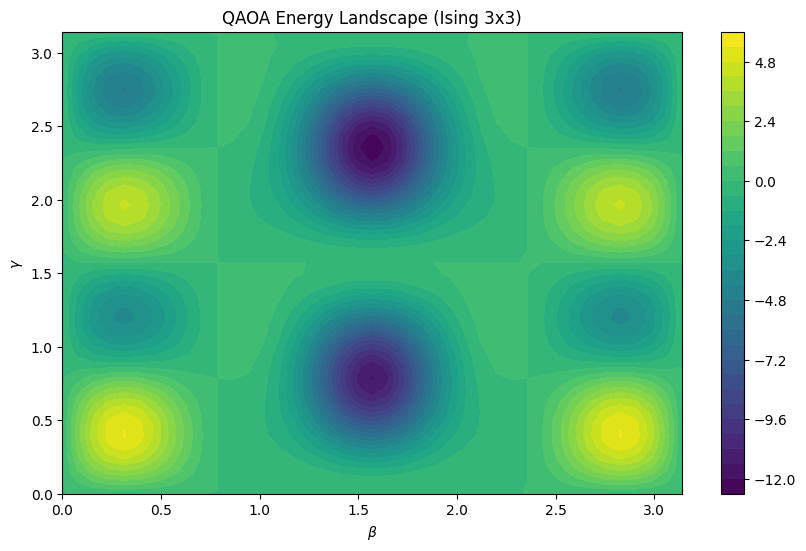

In [30]:
# --- Sweep gamma-beta grid and plot energy landscape ---

grid_size = 41
gamma_vals = np.linspace(0, np.pi, grid_size)
beta_vals = np.linspace(0, np.pi, grid_size)
energies = np.zeros((grid_size, grid_size))

for i, g in enumerate(gamma_vals):
    for j, b in enumerate(beta_vals):
        # ✅ Usamos los parámetros reales del circuito
        sv = Statevector.from_instruction(qaoa_circ.assign_parameters({gammas[0]: g, betas[0]: b}))
        energies[i, j] = energy_from_statevector(sv)

# --- Plot energy landscape ---
G, B = np.meshgrid(beta_vals, gamma_vals)
plt.figure(figsize=(10, 6))
cp = plt.contourf(B, G, energies, levels=30)
plt.colorbar(cp)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$\gamma$')
plt.title('QAOA Energy Landscape (Ising 3x3)')
plt.show()



In [31]:
# Simulate chosen params, show top states and histogram
from qiskit import transpile

chosen_gamma = 0.5
chosen_beta = 0.3
bound = qaoa_circ.assign_parameters([chosen_gamma, chosen_beta])

# Final statevector
sv = Statevector.from_instruction(bound)
final_state = sv.data
probs = np.abs(final_state) ** 2
num_qubits_detected = int(np.log2(len(probs)))

sorted_indices = np.argsort(probs)[-10:][::-1]
print(f'Number of qubits: {num_qubits_detected}')
print('Top states:')
for idx in sorted_indices:
    print(f"|{np.binary_repr(idx, width=num_qubits_detected)}> -> P={probs[idx]:.4f}")

# Plot histogram via AerSimulator (shots)
shots = 2000
circ_meas = bound.copy()
circ_meas.measure_all()
sim = AerSimulator()
transpiled = transpile(circ_meas, sim)
job = sim.run(transpiled, shots=shots)
counts = job.result().get_counts()
plot_histogram(counts)
plt.show()

Number of qubits: 9
Top states:
|000000000> -> P=0.1015
|111111111> -> P=0.0275
|000000111> -> P=0.0137
|100100100> -> P=0.0137
|001001001> -> P=0.0137
|111000000> -> P=0.0137
|000001001> -> P=0.0137
|100100000> -> P=0.0137
|000000110> -> P=0.0137
|000100100> -> P=0.0137


Número detectado de qubits: 9

Top estados más probables:
|000101000>  →  P = 0.0105
|010000010>  →  P = 0.0105
|000111111>  →  P = 0.0095
|110110110>  →  P = 0.0095
|111111000>  →  P = 0.0095
|011011011>  →  P = 0.0095
|101010101>  →  P = 0.0090
|001000100>  →  P = 0.0088
|100000001>  →  P = 0.0088
|111101101>  →  P = 0.0074


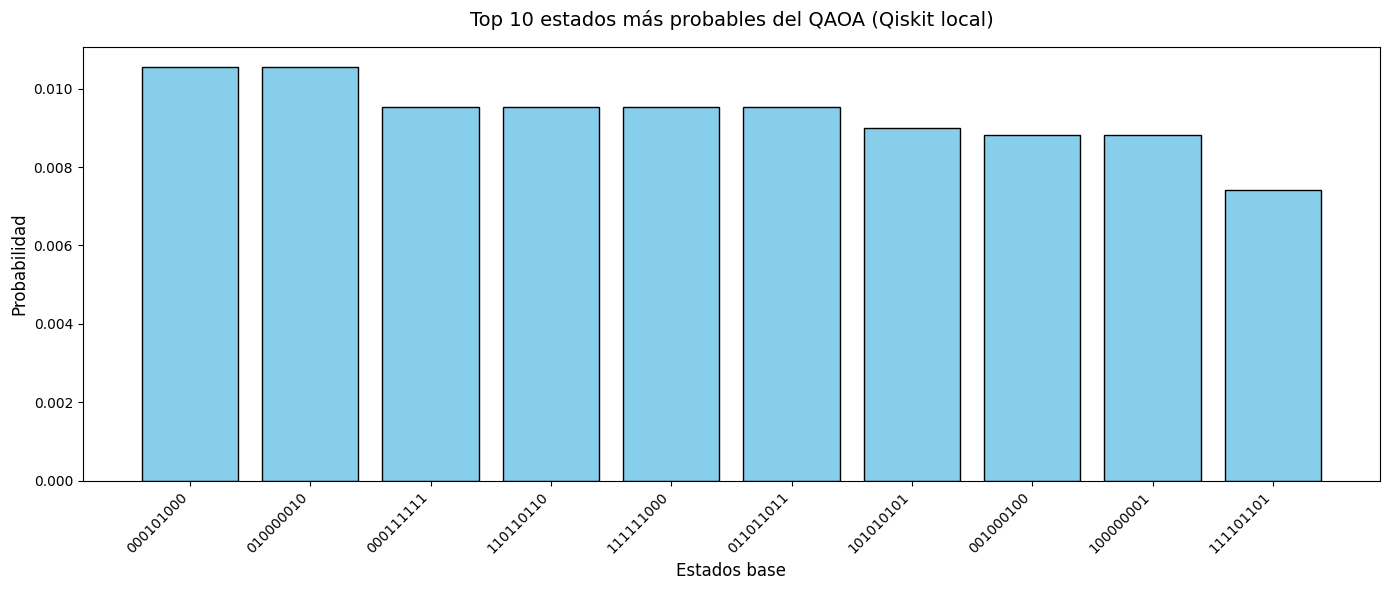

In [34]:
final_sv = Statevector.from_instruction(
    qaoa_circ.assign_parameters({gammas[0]: np.pi / 4, betas[0]: np.pi / 6})
)

# Calculamos las probabilidades
probs = np.abs(final_sv.data) ** 2
sorted_indices = np.argsort(probs)[-10:][::-1]

num_qubits = int(np.log2(len(probs)))
print(f"Número detectado de qubits: {num_qubits}\n")

print("Top estados más probables:")
for idx in sorted_indices:
    bitstring = np.binary_repr(idx, width=num_qubits)
    print(f"|{bitstring}>  →  P = {probs[idx]:.4f}")

# --- Visualización tipo Cirq ---
plt.figure(figsize=(14, 6))  # Más ancho, más claro
bars = plt.bar(range(10), probs[sorted_indices], color="skyblue", edgecolor="black")

# Etiquetas de estados en el eje x
plt.xticks(
    range(10),
    [np.binary_repr(i, width=num_qubits) for i in sorted_indices],
    rotation=45,
    ha="right"
)

plt.xlabel("Estados base", fontsize=12)
plt.ylabel("Probabilidad", fontsize=12)
plt.title("Top 10 estados más probables del QAOA (Qiskit local)", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

